In [122]:
import tensorflow.keras as keras
import tensorflow as tf
import numpy as np
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import uproot
import pandas as pd
import awkward as ak
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler
import seaborn as sns
import tensorflow_decision_forests as tfdf
import tensorflow_docs as tfdocs
import tensorflow_docs.modeling
import tensorflow_docs.plots
from keras.callbacks import LearningRateScheduler

In [123]:
def open_root_files(file_names,tree):
    file = uproot.open(file_names)
    tree_name = file[tree]
    return tree_name

def create_heat_map(df):
    corr = df.corr()
    sns.heatmap(corr, 
    cmap='RdYlGn', 
    xticklabels=corr.columns.values,
    yticklabels=corr.columns.values)
    plt.show()

def create_tensor_object(train_variables,dict):
    df = pd.DataFrame()
    key = list(dict.keys())[0]

    for var in train_variables:
        if(var == "classification"):
            continue
        else:
            varDf = dict[key][var].array(library = 'pd')
            if(varDf.index.nlevels == 2):
                df[var] = varDf.reset_index(level=1, drop=True)
            else:
                df[var] = varDf

    if "signal" in key:
        print("SIGNAL CLASSIFICATION SET TO 1", key)
        df.insert(0, 'classification', 1)
    else:
        print("BACKGROUND CLASSIFICATION SET TO 0", key)
        df.insert(0, 'classification', 0)
    
    #split the data into train and testing set
    train_df, test_df = train_test_split(df, test_size=0.2)
    
    train_df, val_df = train_test_split(train_df, test_size=0.2)
    
    train_df.filter(train_df['weight'] > 0)
    test_df.filter(test_df['weight'] > 0)
    val_df.filter(val_df['weight'] > 0)
    
    train_df_class = train_df.pop('classification')
    train_df_weights = train_df.pop('weight')
    test_df_class = test_df.pop('classification')
    test_df_weights = test_df.pop('weight')
    val_df_class = val_df.pop('classification')
    val_df_weights = val_df.pop('weight')

    #create heat map of training variables
    hmap = create_heat_map(train_df)
    
    return train_df, train_df_class, train_df_weights, test_df, test_df_class, test_df_weights, val_df, val_df_class, val_df_weights

def plot_roc_curve(fpr, tpr, label=None):
    plt.plot(fpr, tpr, linewidth=2, label=label)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.axis([0, 1, 0, 1])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.show()
    
def plot_loss(fit):
    plt.plot(fit.history['loss'])
    plt.plot(fit.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()

def plot_accuracy(fit):
    plt.plot(fit.history['accuracy'])
    plt.plot(fit.history['val_accuracy'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()
    
def custom_LearningRate_schedular(epoch):
    if epoch < 5:
        return 0.01
    else:
        return 0.01 * tf.math.exp(0.1 * (10 - epoch))

    
def get_model(metric, bias, train_tensor):
    model = keras.Sequential([
    keras.layers.Dense(4, activation='relu', input_shape=(train_tensor.shape[1],), bias_initializer=keras.initializers.Constant(bias)),
    # keras.layers.Dense(128, activation='relu'),
    # keras.layers.Dense(128, activation='relu'),
    # keras.layers.Dense(128, activation='relu'),
    # keras.layers.Dense(128, activation='relu'),
    # keras.layers.Dense(64, activation='relu'),
    # keras.layers.Dense(64, activation='relu'),
    # keras.layers.Dense(64, activation='relu'),
    # keras.layers.Dense(64, activation='relu'),
    # keras.layers.Dense(32, activation='relu'),
    # keras.layers.Dense(16, activation='relu'),
    # keras.layers.Dense(8, activation='relu'),
    keras.layers.Dense(1, activation=tf.nn.sigmoid)
    ])
    model.compile(optimizer=tf.optimizers.SGD(learning_rate=0.001),
                loss=tf.keras.losses.BinaryCrossentropy(
                        name='binary_crossentropy'),
                metrics=[metric])
    # model.layers[0].bias.assign([bias])
    return model


def boosted_decision_tree():
    model = tfdf.keras.GradientBoostedTreesModel()
    return model

def random_forest_tree():
    model = tfdf.keras.RandomForestModel()
    return model

In [124]:
#open the files
signal_file_e = open_root_files("mc16e_signal.root","nominal")
#signal_file_d = open_root_files("~/Physics/HWWAnalysis/ntuples/mc16d_signal.root","nominal")
#signal_file_a = open_root_files("~/Physics/HWWAnalysis/ntuples/mc16a_signal.root","nominal")
ttbar_file_e = open_root_files("mc16e_ttbar.root","nominal")
#ttbar_file_d = open_root_files("~/Physics/HWWAnalysis/ntuples/mc16d_ttbar.root","nominal")
#ttbar_file_a = open_root_files("~/Physics/HWWAnalysis/ntuples/mc16a_ttbar.root","nominal")
#wjets_file_e = open_root_files("~/Physics/HWWAnalysis/ntuples/mc16e_wjets.root","nominal")
#wjets_file_d = open_root_files("~/Physics/HWWAnalysis/ntuples/mc16d_wjets.root","nominal")
#wjets_file_a = open_root_files("~/Physics/HWWAnalysis/ntuples/mc16a_wjets.root","nominal")
#diboson_file_e = open_root_files("~/Physics/HWWAnalysis/ntuples/mc16e_diboson.root","nominal")
#diboson_file_d = open_root_files("~/Physics/HWWAnalysis/ntuples/mc16d_diboson.root","nominal")
#diboson_file_a = open_root_files("~/Physics/HWWAnalysis/ntuples/mc16a_diboson.root","nominal")
#zjets_file_e = open_root_files("~/Physics/HWWAnalysis/ntuples/mc16e_zjets.root","nominal")
#zjets_file_d = open_root_files("~/Physics/HWWAnalysis/ntuples/mc16d_zjets.root","nominal")
#zjets_file_a = open_root_files("~/Physics/HWWAnalysis/ntuples/mc16a_zjets.root","nominal")
#singletop_file_e = open_root_files("~/Physics/HWWAnalysis/ntuples/mc16e_singletop.root","nominal")
#singletop_file_d = open_root_files("~/Physics/HWWAnalysis/ntuples/mc16d_singletop.root","nominal")
#singletop_file_a = open_root_files("~/Physics/HWWAnalysis/ntuples/mc16a_singletop.root","nominal")

SIGNAL CLASSIFICATION SET TO 1 signal_e


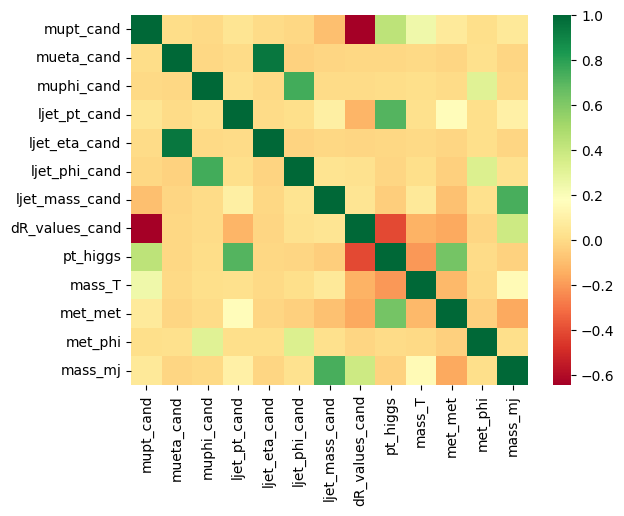

BACKGROUND CLASSIFICATION SET TO 0 ttbar_e


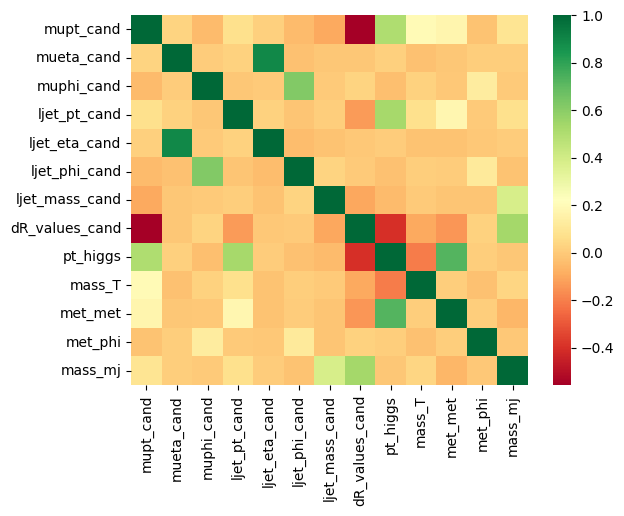

entry
2275    0.002791
1497    0.009108
740     0.011483
3130    0.005105
2199    0.012516
          ...   
1483    0.004435
1370    0.010481
220     0.008210
1967    0.002346
1059    0.008656
Name: weight, Length: 2124, dtype: float64
entry
2397    0.090636
1560    0.138308
2701    0.114807
184     0.098548
209     0.082516
          ...   
1230    0.138362
1913    0.075929
3015    0.128076
1541    0.113007
750     0.157126
Name: weight, Length: 2259, dtype: float64
Examples:  Total: 4383  Positive: 2124  Negative: 2259  Ratio: 0.48459958932238195
[1 1 1 ... 0 0 0]
[0.00279096 0.00910824 0.0114834  ... 0.12807602 0.11300676 0.15712585]
[241.57616771  14.26619933]
Weighted Training Events:  Total: 255.84236704366623  Positive: 14.266199329837455  Negative: 241.57616771382877  Ratio: 0.055761676592847316
Weighted Test Events:  Total: 81.26434553844045  Positive: 4.48044552856892  Negative: 76.78390000987153  Ratio: 0.05513421044472124
Weighted Validation Events:  Total: 62.8274611428673

In [125]:
# variables = ['classification','mupt_cand', 'mueta_cand', 'muphi_cand', 'ljet_pt_cand', 'ljet_eta_cand',\
#                    'ljet_phi_cand', 'ljet_mass_cand', 'dR_values_cand', 'pt_higgs',\
#                    'mass_T', 'met_met', 'met_phi', 'mass_mj', 'weight']
# variables = ['classification','mupt_cand','ljet_pt_cand','ljet_mass_cand','dR_values_cand','pt_higgs','mass_T', 'met_met', 'mass_mj', 'weight']
variables = ['classification', 'mupt_cand', 'mueta_cand', 'muphi_cand', 'ljet_pt_cand', 'ljet_eta_cand',\
                   'ljet_phi_cand', 'ljet_mass_cand', 'dR_values_cand', 'pt_higgs',\
                   'mass_T', 'met_met', 'met_phi', 'mass_mj', 'weight']

signal_train_e, signal_train_class_e, signal_train_weights_e, signal_test_e, signal_test_class_e, signal_test_weights_e, signal_val_e, signal_val_class_e, signal_val_weights_e = create_tensor_object(variables, {"signal_e" : signal_file_e})
ttbar_train_e, ttbar_train_class_e, ttbar_train_weights_e, ttbar_test_e, ttbar_test_class_e, ttbar_test_weights_e, ttbar_val_e, ttbar_val_class_e, ttbar_val_weights_e  = create_tensor_object(variables, {"ttbar_e" : ttbar_file_e})

train_df = pd.concat([signal_train_e, ttbar_train_e])
train_class = np.concatenate([signal_train_class_e, ttbar_train_class_e])
train_weight = np.concatenate([signal_train_weights_e, ttbar_train_weights_e])
print(signal_train_weights_e)
print(ttbar_train_weights_e)

test_df = pd.concat([signal_test_e, ttbar_test_e])
test_class = np.concatenate([signal_test_class_e, ttbar_test_class_e])
test_weight = np.concatenate([signal_test_weights_e, ttbar_test_weights_e])

val_df = pd.concat([signal_val_e, ttbar_val_e])
val_class = np.concatenate([signal_val_class_e, ttbar_val_class_e])
val_weight = np.concatenate([signal_val_weights_e, ttbar_val_weights_e])

scaled_train_df = StandardScaler().fit_transform(train_df)
scaled_test_df = StandardScaler().fit_transform(test_df)
scaled_val_df = StandardScaler().fit_transform(val_df)

#print total number of events in each sample
neg, pos = np.bincount(train_class)
total = neg + pos
print('Examples:  Total: {}  Positive: {}  Negative: {}  Ratio: {}'.format(total, pos, neg, pos / total))
class_weight = {0: total/(2*neg), 1: total/(2*pos)}

#print weighted number of Total, Positive, Negative, and Ratio
neg_weighted, pos_weighted = np.bincount(train_class, weights=train_weight)
print(train_class)
print(train_weight)
print(np.bincount(train_class, weights=train_weight))
total_weighted = neg_weighted + pos_weighted
print('Weighted Training Events:  Total: {}  Positive: {}  Negative: {}  Ratio: {}'.format(total_weighted, pos_weighted, neg_weighted, pos_weighted / total_weighted))

#print weighted number of total, positive, negative, and ratio for test set 
neg_weighted_test, pos_weighted_test = np.bincount(test_class, weights=test_weight)
total_weighted_test = neg_weighted_test + pos_weighted_test
print('Weighted Test Events:  Total: {}  Positive: {}  Negative: {}  Ratio: {}'.format(total_weighted_test, pos_weighted_test, neg_weighted_test, pos_weighted_test / total_weighted_test))

#print weighted number of total, positive, negative, and ratio for validation set
neg_weighted_val, pos_weighted_val = np.bincount(val_class, weights=val_weight)
total_weighted_val = neg_weighted_val + pos_weighted_val
print('Weighted Validation Events:  Total: {}  Positive: {}  Negative: {}  Ratio: {}'.format(total_weighted_val, pos_weighted_val, neg_weighted_val, pos_weighted_val / total_weighted_val))

#print total numbers
print('Total Events:  Total: {}  Positive: {}  Negative: {}  Ratio: {}'.format(total_weighted + total_weighted_val + total_weighted_test,\
       pos_weighted + pos_weighted_val + pos_weighted_test, neg_weighted + neg_weighted_val + neg_weighted_test, \
       (pos_weighted + pos_weighted_val + pos_weighted_test) / (total_weighted + total_weighted_val + total_weighted_test)))

In [126]:
#Make plots for all of the input training variables
# for i in range(len(train_df.columns)):
#     plt.hist(train_df[train_df.columns[i]][train_class == 0], bins=50, histtype='step', label='Background', color='blue', weights=train_weight[train_class == 0])
#     plt.hist(train_df[train_df.columns[i]][train_class == 1], bins=50, histtype='step', label='Signal', color='red', weights=train_weight[train_class == 1])
#     plt.xlabel(train_df.columns[i])
#     plt.legend()
#     plt.show()
#     # plt.savefig('plots/{}_train.png'.format(train_df.columns[i]))
#     # plt.clf()

#set new weight using class weight
train_weight = train_weight * [class_weight[i] for i in train_class]
bias = pos / total

In [127]:
#set new weight using class weight
# train_weight = train_weight * [class_weight[i] for i in train_class]
# bias = pos / total

In [128]:
METRICS = [
        keras.metrics.TruePositives(name='tp'),
        keras.metrics.FalsePositives(name='fp'),
        keras.metrics.TrueNegatives(name='tn'),
        keras.metrics.FalseNegatives(name='fn'),
        keras.metrics.BinaryAccuracy(name='accuracy'),
        keras.metrics.Precision(name='precision'),
        keras.metrics.Recall(name='recall'),
        keras.metrics.AUC(name='auc'),
        keras.metrics.AUC(name='prc', curve='PR'),
]
early_stopping = keras.callbacks.EarlyStopping(monitor='val_loss', patience=100, mode='min')
cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath="checkpoint.ckpt", save_weights_only=True, verbose=1)
nn_model = get_model(METRICS, bias, scaled_train_df)
nn_fit = nn_model.fit(scaled_train_df, train_class, batch_size=256, epochs=750, validation_data=(scaled_val_df, val_class), sample_weight=pd.Series(train_weight).to_frame('weight'), callbacks=[early_stopping, cp_callback])
# validation_data=(scaled_val_df, val_class),
y_scores = nn_model.predict(scaled_test_df)
nn_model.save('nn_model_4_hidden_256_128_64_32_16_8_input.h5')

Epoch 1/750
14/18 [======================>.......] - ETA: 0s - loss: 0.0681 - tp: 1681.0000 - fp: 1705.0000 - tn: 155.0000 - fn: 43.0000 - accuracy: 0.5123 - precision: 0.4965 - recall: 0.9751 - auc: 0.5737 - prc: 0.5211
Epoch 1: saving model to checkpoint.ckpt
18/18 [==============================] - 3s 82ms/step - loss: 0.0673 - tp: 2072.0000 - fp: 2074.0000 - tn: 185.0000 - fn: 52.0000 - accuracy: 0.5149 - precision: 0.4998 - recall: 0.9755 - auc: 0.5757 - prc: 0.5255 - val_loss: 0.8010 - val_tp: 517.0000 - val_fp: 505.0000 - val_tn: 60.0000 - val_fn: 14.0000 - val_accuracy: 0.5265 - val_precision: 0.5059 - val_recall: 0.9736 - val_auc: 0.6130 - val_prc: 0.5455
Epoch 2/750
16/18 [=========================>....] - ETA: 0s - loss: 0.0671 - tp: 1933.0000 - fp: 1939.0000 - tn: 176.0000 - fn: 48.0000 - accuracy: 0.5149 - precision: 0.4992 - recall: 0.9758 - auc: 0.5789 - prc: 0.5254
Epoch 2: saving model to checkpoint.ckpt
18/18 [==============================] - 1s 36ms/step - loss: 0.0

[1.9289843  0.9289843  0.8354861  0.81020904 0.7377935  0.71116364
 0.70916957 0.7049013  0.6835344  0.6797564  0.6769879  0.6720526
 0.6677361  0.66414034 0.664108   0.6616554  0.66055655 0.65629286
 0.65342444 0.64926    0.6492112  0.6452608  0.6428254  0.6423414
 0.6414632  0.6345927  0.6345179  0.633428   0.63296485 0.63184994
 0.6314312  0.6288644  0.6272293  0.6266502  0.6251365  0.6232917
 0.6219334  0.62183034 0.6213909  0.6196399  0.6179901  0.6173034
 0.61599034 0.6147083  0.6138329  0.6104515  0.6070827  0.6057782
 0.60428697 0.60338557 0.60151505 0.5976478  0.5973601  0.59575075
 0.5953512  0.592866   0.5919064  0.5881145  0.58634865 0.58495986
 0.58434916 0.58319163 0.5824295  0.5823104  0.58190334 0.58162653
 0.58093894 0.5787541  0.57856494 0.57574356 0.57459086 0.57394725
 0.573843   0.5735115  0.57294506 0.5724615  0.57121164 0.57117796
 0.57066983 0.5699478  0.5690153  0.56838435 0.5683219  0.5667746
 0.56572753 0.5643508  0.56386894 0.56240505 0.56227136 0.56189865
 

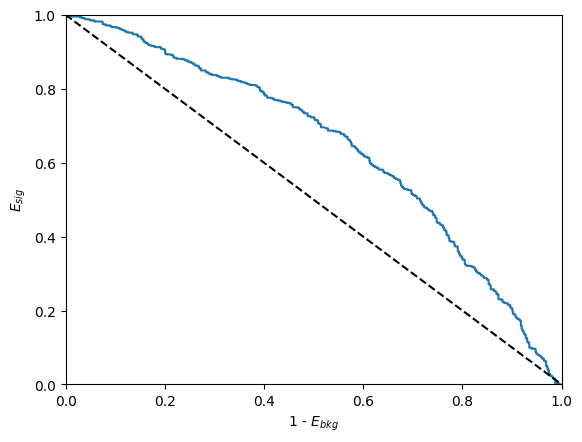

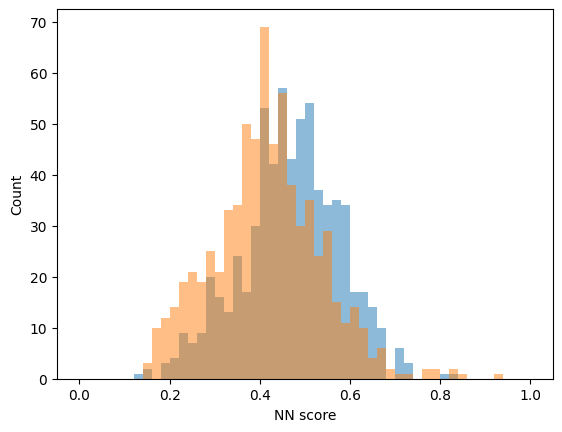

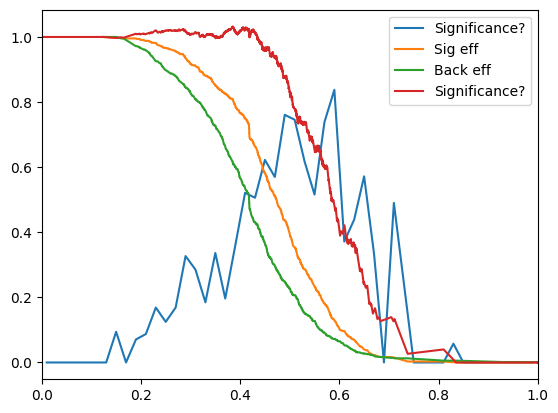

Maximum significance of 0.83762162014752 occurs at nn = 0.5900000035762787


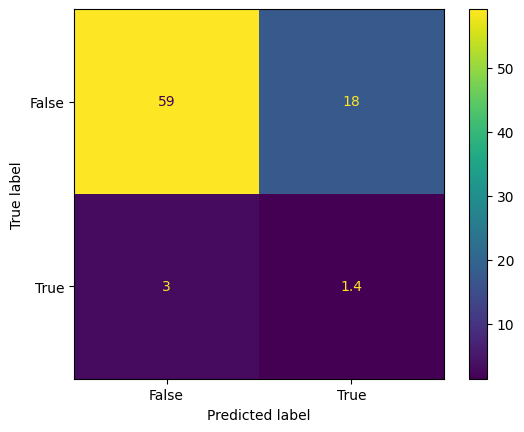

In [129]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
import matplotlib.pyplot as plt
from sklearn import preprocessing

# nn_model = keras.models.load_model('nn_model.h5')
# y_scores = nn_model.predict(scaled_test_df)
y_pred = np.round(y_scores)

# nn_model.summary()

nn_signal_scores = y_scores[test_class == 1]
nn_background_scores = y_scores[test_class == 0]

nn_fakes, nn_reals, thresholds = roc_curve(test_class, y_scores)

print(thresholds)

#print("NN AUC: ", auc(nn_fakes, nn_reals))

# nn_loss_plot = plot_loss(nn_fit)
# nn_accuracy_plot = plot_accuracy(nn_fit)

# plot_roc_curve(nn_fakes, nn_reals)

# plot signal and background scores
# plt.plot(nn_fakes, nn_reals, label="NN")
# plt.legend()
# plt.show()

# , weights=test_weight[test_class == 1]
# , weights=test_weight[test_class == 0]

plt.plot(1 - nn_fakes, nn_reals)
plt.xlabel('1 - $E_{bkg}$')
plt.ylabel('$E_{sig}$')
plt.plot([0, 1], [1, 0], 'k--')
plt.axis([0, 1, 0, 1])
plt.show()

#plot signal and background scores
entries, bin_edges, c = plt.hist(nn_signal_scores, bins=50, range = (0, 1), alpha = 0.5, label='signal')
entries1, bin_edges1, c1 = plt.hist(nn_background_scores, bins=50, range = (0, 1), alpha = 0.5, label='background')
plt.xlabel('NN score')
plt.ylabel('Count')
# plt.yscale('log')
plt.show()

entries = preprocessing.normalize([entries])[0]
entries1 = preprocessing.normalize([entries1])[0]

# hold the significance values for the entries of the signal and background arrays
significance = np.zeros(entries.size)
# sig 2?
significance2 = np.zeros(thresholds.size + 2)
# holds the center of bins which will 
bin_centers = np.zeros(entries.size)

for i in range(entries.size):
    if(entries1[i]!= 0):
        significance[i] = entries[i] / np.sqrt(entries1[i])
    bin_centers[i] = (bin_edges[i] + bin_edges[i + 1]) / 2

significance2[significance2.size - 1] = 1
for i in range(thresholds.size):
    if(nn_fakes[i] != 0):
        significance2[i + 1] = nn_reals[i] / np.sqrt(nn_fakes[i])

thresholds2 = np.insert(thresholds, 0, 1)
thresholds2 = np.append(thresholds2, 0)

plt.plot(bin_centers, significance, label = "Significance?")
plt.plot(thresholds, nn_reals, label = "Sig eff")
plt.plot(thresholds, nn_fakes, label = "Back eff")
plt.plot(thresholds2, significance2, label = "Significance?")
plt.xlim([0, 1])
plt.legend()
plt.show()

# plt.plot(bin_centers, significance, color = 'b')
# plt.plot(bin_centers, entries, '--')
# plt.plot(bin_centers, entries1, '--')
# plt.show()

print(f'Maximum significance of {np.max(significance)} occurs at nn = {bin_centers[np.where(significance == np.max(significance))][0]}')

# plt.hist(nn_signal_scores, bins=20, alpha = 0.5, label='background')
# plt.xlim([0, 1])
# # plt.yscale('log')
# plt.show()

#sum of weights
# print(sum(entries * np.diff(bin_edges)))
# print(sum(entries1 * np.diff(bin_edges1)))

#plot confusion matrix
confmatrix = confusion_matrix(test_class, y_pred, sample_weight=test_weight)
cm_display = ConfusionMatrixDisplay(confusion_matrix = confmatrix, display_labels = [False, True])
cm_display.plot()
plt.show()

In [130]:
bdt_model = boosted_decision_tree()

bdt_fit = bdt_model.fit(scaled_train_df, train_class, batch_size=256, validation_data=(scaled_val_df, val_class), sample_weight=pd.Series(train_weight).to_frame('weight'), callbacks=[early_stopping, cp_callback])

bdt_y_scores = bdt_model.predict(scaled_test_df)

Use /tmp/tmper_w3qxv as temporary training directory


Reading training dataset...
Training dataset read in 0:00:00.576056. Found 4383 examples.
Reading validation dataset...
Num validation examples: tf.Tensor(1096, shape=(), dtype=int32)
Validation dataset read in 0:00:00.290802. Found 1096 examples.
Training model...


2022-12-08 02:18:14.403937: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1765] Subsample hyperparameter given but sampling method does not match.
2022-12-08 02:18:14.406134: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1778] GOSS alpha hyperparameter given but GOSS is disabled.
2022-12-08 02:18:14.406153: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1787] GOSS beta hyperparameter given but GOSS is disabled.
2022-12-08 02:18:14.406160: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1799] SelGB ratio hyperparameter given but SelGB is disabled.
2022-12-08 02:18:14.421685: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:451] Default loss set to BINOMIAL_LOG_LIKELIHOOD
2022-12-08 02:18:14.422548: I external/ydf/yggdrasil_decision_

Model trained in 0:00:01.382186
Compiling model...


2022-12-08 02:18:15.671158: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1567] Create final snapshot of the model at iteration 82
2022-12-08 02:18:15.680094: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:247] Truncates the model to 53 tree(s) i.e. 53  iteration(s).
2022-12-08 02:18:15.680315: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:309] Final model num-trees:53 valid-loss:0.851649 valid-accuracy:0.827555
[INFO 2022-12-08T02:18:15.712800207-05:00 kernel.cc:1175] Loading model from path /tmp/tmper_w3qxv/model/ with prefix 1a70029e772b40da
[INFO 2022-12-08T02:18:15.732002528-05:00 abstract_model.cc:1306] Engine "GradientBoostedTreesQuickScorerExtended" built
[INFO 2022-12-08T02:18:15.732062282-05:00 kernel.cc:1021] Use fast generic engine


Model compiled.

Epoch 1: saving model to checkpoint.ckpt
43/43 [==============================] - 0s 3ms/step


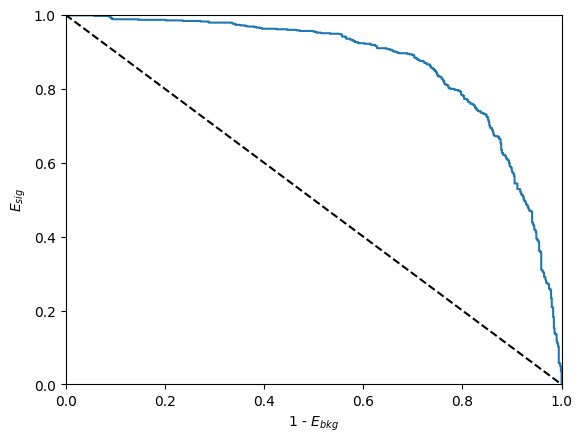

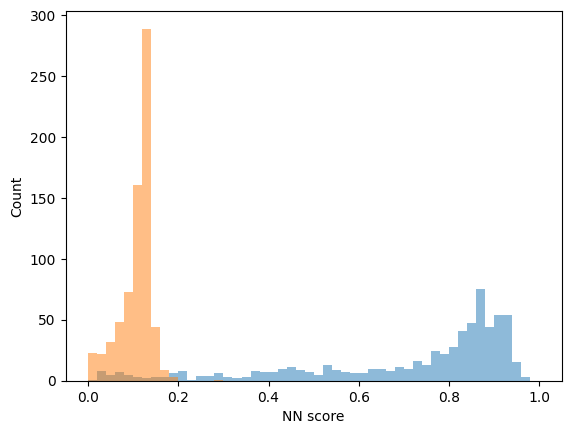

ValueError: x and y must have same first dimension, but have shapes (403,) and (638,)

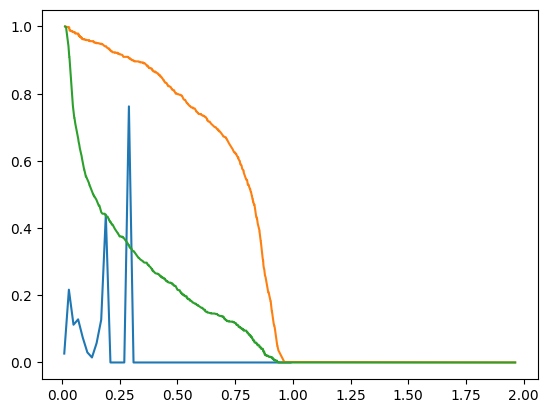

In [131]:
y_pred = np.round(bdt_y_scores)

# bdt_model.summary()

nn_signal_scores = bdt_y_scores[test_class == 1]
nn_background_scores = bdt_y_scores[test_class == 0]

nn_signal_weights = test_weight[test_class == 1]
nn_background_scores = test_weight[test_class == 0]

nn_fakes, nn_reals, thresholds = roc_curve(test_class, bdt_y_scores)

# print("NN AUC: ", auc(nn_fakes, nn_reals))

# plot_roc_curve(nn_fakes, nn_reals)

plt.plot(1 - nn_fakes, nn_reals)
plt.xlabel('1 - $E_{bkg}$')
plt.ylabel('$E_{sig}$')
plt.plot([0, 1], [1, 0], 'k--')
plt.axis([0, 1, 0, 1])
plt.show()

#plot signal and background scores
entries, bin_edges, c = plt.hist(nn_signal_scores, bins=50, range = (0, 1), alpha = 0.5, label='signal')
entries1, bin_edges1, c1 = plt.hist(nn_background_scores, bins=50, range = (0, 1), alpha = 0.5, label='background')
plt.xlabel('NN score')
plt.ylabel('Count')
# plt.yscale('log')
plt.show()

entries = preprocessing.normalize([entries])[0]
entries1 = preprocessing.normalize([entries1])[0]

# hold the significance values for the entries of the signal and background arrays
significance = np.zeros(entries.size)
# holds the center of bins which will 
bin_centers = np.zeros(entries.size)

for i in range(entries.size):
    if(entries1[i]!= 0):
        significance[i] = entries[i] / np.sqrt(entries1[i])
    bin_centers[i] = (bin_edges[i] + bin_edges[i + 1]) / 2

significance2[significance2.size - 1] = 1
for i in range(thresholds.size):
    if(nn_fakes[i] != 0):
        significance2[i + 1] = nn_reals[i] / np.sqrt(nn_fakes[i])

thresholds2 = np.insert(thresholds, 0, 1)
thresholds2 = np.append(thresholds2, 0)

plt.plot(bin_centers, significance, label = "Significance?")
plt.plot(thresholds, nn_reals, label = "Sig eff")
plt.plot(thresholds, nn_fakes, label = "Back eff")
plt.plot(thresholds2, significance2, label = "Significance?")
plt.xlim([0, 1])
plt.legend()
plt.show()

# plt.plot(bin_centers, significance, color = 'b')
# plt.plot(bin_centers, entries, '--')
# plt.plot(bin_centers, entries1, '--')
# plt.show()

print(f'Maximum significance of {np.max(significance)} occurs at nn = {bin_centers[np.where(significance == np.max(significance))][0]}')

#sum of weights
# print(sum(entries * np.diff(bin_edges)))
# print(sum(entries1 * np.diff(bin_edges1)))

#plot confusion matrix
confmatrix = confusion_matrix(test_class, y_pred, sample_weight=test_weight)
cm_display = ConfusionMatrixDisplay(confusion_matrix = confmatrix, display_labels = [False, True])
cm_display.plot()
plt.show()

In [ ]:
rft_model = random_forest_tree()

rft_fit = rft_model.fit(scaled_train_df, train_class, batch_size=256, validation_data=(scaled_val_df, val_class), sample_weight=pd.Series(train_weight).to_frame('weight'), callbacks=[early_stopping, cp_callback])

rft_y_scores = rft_model.predict(scaled_test_df)

Use /tmp/tmpklk_j70c as temporary training directory


Reading training dataset...
Training dataset read in 0:00:01.024281. Found 4383 examples.
Reading validation dataset...
Num validation examples: tf.Tensor(1096, shape=(), dtype=int32)
Validation dataset read in 0:00:00.390977. Found 1096 examples.
Training model...


[INFO 2022-12-07T16:00:31.696116784-05:00 kernel.cc:1175] Loading model from path /tmp/tmpklk_j70c/model/ with prefix ea9c6fad6e90415c


Model trained in 0:00:02.245390
Compiling model...


[INFO 2022-12-07T16:00:32.693433361-05:00 kernel.cc:1021] Use fast generic engine


Model compiled.

Epoch 1: saving model to checkpoint.ckpt
43/43 [==============================] - 0s 5ms/step


Model: "random_forest_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
Total params: 1
Trainable params: 0
Non-trainable params: 1
_________________________________________________________________
Type: "RANDOM_FOREST"
Task: CLASSIFICATION
Label: "__LABEL"

Input Features (13):
	data:0.0
	data:0.1
	data:0.10
	data:0.11
	data:0.12
	data:0.2
	data:0.3
	data:0.4
	data:0.5
	data:0.6
	data:0.7
	data:0.8
	data:0.9

No weights

Variable Importance: MEAN_MIN_DEPTH:
    1.   "__LABEL" 10.271251 ################
    2.  "data:0.2"  9.152017 #############
    3.  "data:0.5"  9.146006 #############
    4. "data:0.11"  9.111501 #############
    5.  "data:0.1"  9.069000 #############
    6.  "data:0.4"  8.937604 #############
    7.  "data:0.3"  7.658712 ###########
    8.  "data:0.0"  7.489879 ##########
    9.  "data:0.6"  6.834392 #########
   10.  "data:0.8"  6.574995 ########
   11.  "data:0.9"  4.030892 

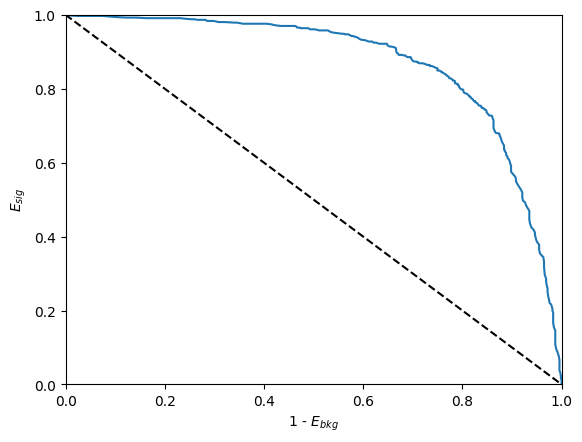

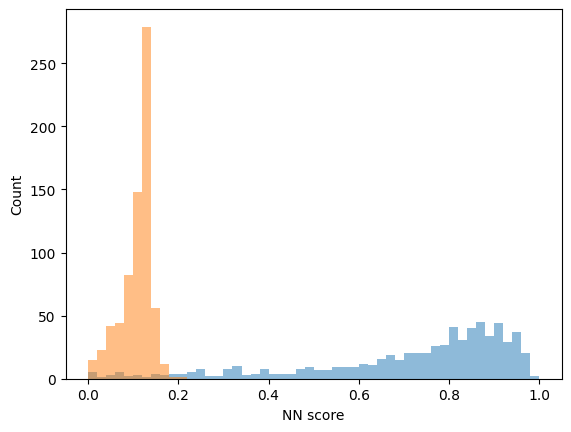

/tmp/ipykernel_214/581096320.py:48: RuntimeWarning: divide by zero encountered in divide
  plt.plot(thresholds, nn_reals / np.sqrt(nn_fakes), label = "Significance?")
/tmp/ipykernel_214/581096320.py:48: RuntimeWarning: invalid value encountered in divide
  plt.plot(thresholds, nn_reals / np.sqrt(nn_fakes), label = "Significance?")


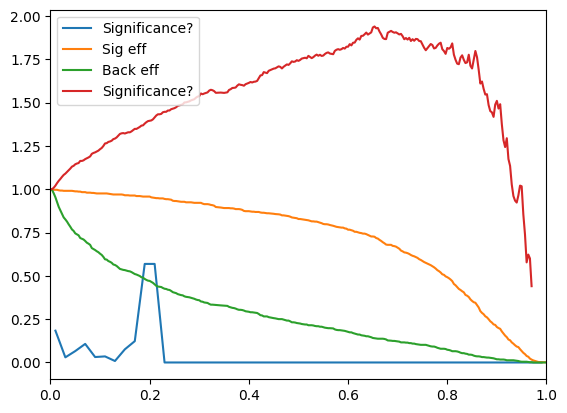

Maximum significance of 0.5690141092661897 occurs at nn = 0.1900000050663948


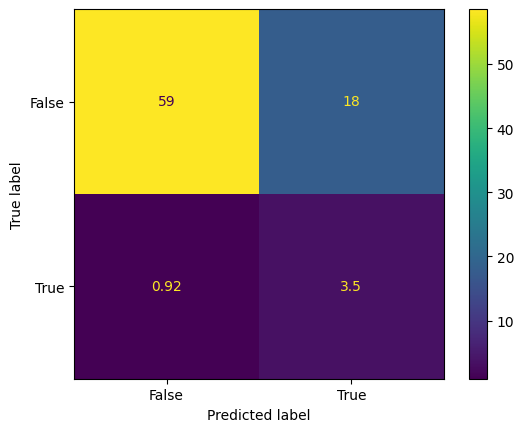

In [ ]:
y_pred = np.round(rft_y_scores)

# rft_model.summary()

nn_signal_scores = rft_y_scores[test_class == 1]
nn_background_scores = rft_y_scores[test_class == 0]

nn_signal_weights = test_weight[test_class == 1]
nn_background_scores = test_weight[test_class == 0]

nn_fakes, nn_reals, thresholds = roc_curve(test_class, rft_y_scores)

# print("NN AUC: ", auc(nn_fakes, nn_reals))

# plot_roc_curve(nn_fakes, nn_reals)

plt.plot(1 - nn_fakes, nn_reals)
plt.xlabel('1 - $E_{bkg}$')
plt.ylabel('$E_{sig}$')
plt.plot([0, 1], [1, 0], 'k--')
plt.axis([0, 1, 0, 1])
plt.show()

#plot signal and background scores
entries, bin_edges, c = plt.hist(nn_signal_scores, bins=50, range = (0, 1), alpha = 0.5, label='signal')
entries1, bin_edges1, c1 = plt.hist(nn_background_scores, bins=50, range = (0, 1), alpha = 0.5, label='background')
plt.xlabel('NN score')
plt.ylabel('Count')
# plt.yscale('log')
plt.show()

entries = preprocessing.normalize([entries])[0]
entries1 = preprocessing.normalize([entries1])[0]

# hold the significance values for the entries of the signal and background arrays
significance = np.zeros(entries.size)
# holds the center of bins which will 
bin_centers = np.zeros(entries.size)

for i in range(entries.size):
    if(entries1[i]!= 0):
        significance[i] = entries[i] / np.sqrt(entries1[i])
    bin_centers[i] = (bin_edges[i] + bin_edges[i + 1]) / 2

significance2[significance2.size - 1] = 1
for i in range(thresholds.size):
    if(nn_fakes[i] != 0):
        significance2[i + 1] = nn_reals[i] / np.sqrt(nn_fakes[i])

thresholds2 = np.insert(thresholds, 0, 1)
thresholds2 = np.append(thresholds2, 0)

plt.plot(bin_centers, significance, label = "Significance?")
plt.plot(thresholds, nn_reals, label = "Sig eff")
plt.plot(thresholds, nn_fakes, label = "Back eff")
plt.plot(thresholds2, significance2, label = "Significance?")
plt.xlim([0, 1])
plt.legend()
plt.show()

# plt.plot(bin_centers, significance, color = 'b')
# plt.plot(bin_centers, entries, '--')
# plt.plot(bin_centers, entries1, '--')
# plt.show()

print(f'Maximum significance of {np.max(significance)} occurs at nn = {bin_centers[np.where(significance == np.max(significance))][0]}')

#sum of weights
# print(sum(entries * np.diff(bin_edges)))
# print(sum(entries1 * np.diff(bin_edges1)))

#plot confusion matrix
confmatrix = confusion_matrix(test_class, y_pred, sample_weight=test_weight)
cm_display = ConfusionMatrixDisplay(confusion_matrix = confmatrix, display_labels = [False, True])
cm_display.plot()
plt.show()